In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

import statsmodels.api as sm
import statsmodels.stats.proportion as smprop
from statsmodels.stats import weightstats as weight

insurance = pd.read_csv('insurance.csv')

In [2]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


# 1. Descriptive Statistic

## Mean Charges of Smoker vs Non Smoker

In [3]:
insurance.groupby('smoker').agg({'charges' : 'mean'})

,charges
smoker,
no,8434.268298
yes,32050.231832


## Mean Age of Female vs Male (Smoker and Non Smoker)

In [4]:
insurance.groupby(['smoker', 'sex']).agg({'age' : 'mean'})


age
smoker sex              
no     female  39.691042
       male    39.061896
yes    female  38.608696
       male    38.446541

## Mean BMI of Smoker vs Non Smoker

In [5]:
insurance.groupby('smoker').agg({'bmi' : 'mean'})

,bmi
smoker,
no,30.651795
yes,30.708449


## Mean Charges of Male vs Female

In [6]:
insurance.groupby('sex').agg({'charges' : 'mean'})

,charges
sex,
female,12569.578844
male,13956.751178


## Mean Charges of Every Region

In [7]:
insurance.groupby('region').agg({'charges' : 'mean'})

,charges
region,
northeast,13406.384516
northwest,12417.575374
southeast,14735.411438
southwest,12346.937377


# 2. Discrete Variable

## Data of each region

In [8]:
insurance.groupby('region').agg({'charges' : 'count'})

,charges
region,
northeast,324
northwest,325
southeast,364
southwest,325


## Smoker vs Non Smoker data

In [9]:
insurance.groupby('smoker').agg({'charges' : 'count'})

,charges
smoker,
no,1064
yes,274


## Probability they were a female if they were a smoker

In [10]:
insurance.groupby(['smoker', 'sex']).agg({'charges' : 'count'})


charges
smoker sex            
no     female      547
       male        517
yes    female      115
       male        159

## Probability they were a smoker if they were a male

In [11]:
insurance.groupby(['sex', 'smoker']).agg({'charges' : 'count'})


charges
sex    smoker         
female no          547
       yes         115
male   no          517
       yes         159

## Probability they had 2 or more children if they were a smoker

In [12]:
insurance.groupby(['smoker', 'children']).agg({'charges' : 'count'})


charges
smoker children         
no     0             459
       1             263
       2             185
       3             118
       4              22
       5              17
yes    0             115
       1              61
       2              55
       3              39
       4               3
       5               1

# 3. Continue Variable

In [55]:
insurance['overweight'] = np.where(insurance['bmi'] >= 25 , 'overweight', 'normal')

In [56]:
insurance_high_charge = insurance[insurance['charges'] > 16700]
insurance_high_charge.reset_index(inplace = True)

In [57]:
insurance_high_charge

,index,age,sex,bmi,children,smoker,region,charges,overweight
0,0,19,female,27.900,0,yes,southwest,16884.92400,overweight
1,3,33,male,22.705,0,no,northwest,21984.47061,normal
2,9,60,female,25.840,0,no,northwest,28923.13692,overweight
3,11,62,female,26.290,0,yes,southeast,27808.72510,overweight
4,14,27,male,42.130,0,yes,southeast,39611.75770,overweight
...,...,...,...,...,...,...,...,...,...
329,1318,35,male,39.710,4,no,northeast,19496.71917,overweight
330,1321,62,male,26.695,0,yes,northeast,28101.33305,overweight
331,1323,42,female,40.370,2,yes,southeast,43896.37630,overweight
332,1328,23,female,24.225,2,no,northeast,22395.74424,normal


## Normal Weight vs Overweight charged high bill

In [58]:
insurance_high_charge.groupby(['overweight']).agg({'charges' : 'count'})

,charges
overweight,
normal,51
overweight,283


## Overweight Smoker vs Overweight non Smoker charged high bill

In [59]:
insurance_high_charge.groupby(['overweight', 'smoker']).agg({'charges' : 'count'})

charges
overweight smoker         
normal     no           12
           yes          39
overweight no           68
           yes         215

# 4. Correlation of Variable

## BMI vs Charged Bill

Text(0, 0.5, 'Charge')

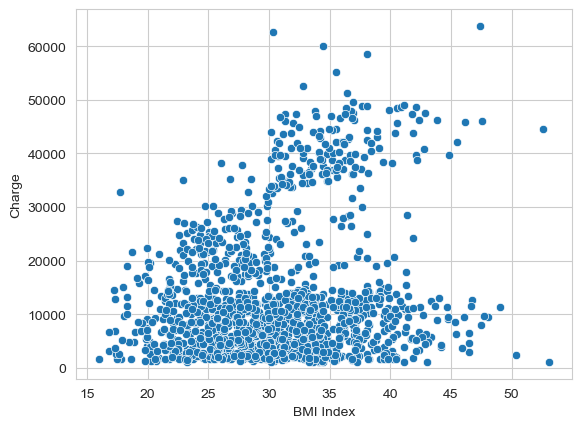

In [18]:
sns.set_style('whitegrid')
bmi_charges = sns.scatterplot(data=insurance, x='bmi', y='charges')
plt.xlabel("BMI Index")
plt.ylabel("Charge")

In [19]:
np.cov(insurance['bmi'], insurance['charges'])

array([[3.71878836e+01, 1.46473044e+04],
       [1.46473044e+04, 1.46652372e+08]])

In [20]:
insurance[['bmi', 'charges']].corr()

,bmi,charges
bmi,1.000000,0.198341
charges,0.198341,1.000000


## Age vs Charged Bill

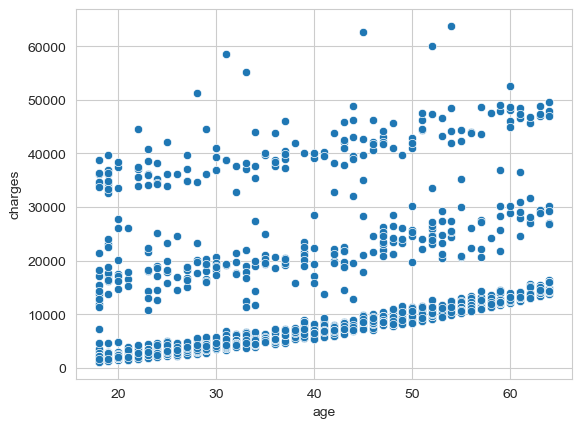

In [21]:
sns.set_style('whitegrid')
age_charges = sns.scatterplot(data=insurance, x='age', y='charges')

In [22]:
np.cov(insurance['age'], insurance['charges'])

array([[1.97401387e+02, 5.08748023e+04],
       [5.08748023e+04, 1.46652372e+08]])

In [23]:
insurance[['age', 'charges']].corr()

,age,charges
age,1.000000,0.299008
charges,0.299008,1.000000


# 5. Statistical Test

## Male smoker proportion is higher than female smoker proportion

In [24]:
sex_smoker = pd.pivot_table(insurance, index = 'sex', columns = 'smoker', values = 'charges', aggfunc='count', margins = True)
sex_smoker

smoker,no,yes,All
sex,,,
female,547,115,662
male,517,159,676
All,1064,274,1338


For proportion, we will use two sample z test

With level of significance = 0.05

In [25]:
z_critical = stats.norm.ppf(1-0.05)
print(z_critical)

1.6448536269514722


#### H0: Proportion of Male Smoker <= Proportion of Female Smoker

#### H1: Proportion of Male Smoker > Proportion of Female Smoker

In [26]:
number_of_smoker = np.array([159, 115])
total_each_sex = np.array([676, 662])

In [27]:
(z_sex_smoker, p_sex) = smprop.proportions_ztest(number_of_smoker, total_each_sex, alternative = 'larger')
print('Z value =', z_sex_smoker)
print('p-value = ', p_sex)

Z value = 2.7867402154855503
p-value =  0.002662057082160266


### H0 is rejected, conclusion: Proportion of Male Smoker is higher than proportion of Female Smoker

## Charged Bill for Male is Higher Than Female

#### H0: Charged Bill for Male <= Charged Bill for Female

#### H1: Charged Bill for Male > Charged Bill for Female

In [28]:
male_sample = insurance[insurance['sex'] == 'male']
male_sample.reset_index(inplace = True)
male_list = male_sample['charges'].tolist()
n_male = len(male_list)

In [29]:
female_sample = insurance[insurance['sex'] == 'female']
female_sample.reset_index(inplace = True)
female_list = female_sample['charges'].tolist()
n_female = len(female_list)

In [46]:
print('Mean charge for male customer: ', np.mean(male_list))
print('Mean charge for female customer: ', np.mean(female_list))

Mean charge for male customer:  13956.751177721893
Mean charge for female customer:  12569.578843835347


In [31]:
(t_sex_charge, p_sex_charge) = stats.ttest_ind(male_list, female_list, nan_policy='raise', alternative='greater')
print('t value =', t_sex_charge)
print('p-value = ', p_sex_charge)

t value = 2.097546590051688
p-value =  0.01806636050296488


In [32]:
dof_male_female = len(male_list) + len(female_list) - 2

In [33]:
t_critical_malefemale = stats.t.ppf(1-0.05,dof_male_female)
print(t_critical_malefemale)

1.6459949688112576


t value = 2.09 is higher than t critical 1.65

### H0 is rejected, conclusion: Charged Bill for Male > Charged Bill for Female

## Charged Bill for Overweight people is Higher than Normal People

#### H0: Mean Charged Bill for Overweight <= Mean Charged Bill for Normal

#### H1: Mean Charged Bill for Overweight > Mean Charged Bill for Normal

In [49]:
overweight_sample = insurance[insurance['bmi'] >= 25]
overweight_sample.reset_index(inplace = True)
overweight_list = overweight_sample['charges'].tolist()
n_overweight = len(overweight_list)

In [50]:
normalweight_sample = insurance[insurance['bmi'] < 25]
normalweight_sample.reset_index(inplace = True)
normalweight_list = normalweight_sample['charges'].tolist()
n_normalweight = len(normalweight_list)

In [51]:
print('Mean charge for overweight customer: ',np.mean(overweight_list))
print('Mean charge for normal customer: ',np.mean(normalweight_list))

Mean charge for overweight customer:  13940.237872405307
Mean charge for normal customer:  10282.224474367347


In [52]:
(t_weight_charge, p_weight_charge) = stats.ttest_ind(overweight_list, normalweight_list, nan_policy='raise', alternative='greater')
print('t value =', t_weight_charge)
print('p-value = ', p_weight_charge)

t value = 4.301200277037612
p-value =  9.111530471784549e-06


In [53]:
dof_weight = len(overweight_list) + len(normalweight_list) - 2

In [54]:
t_critical_weight = stats.t.ppf(1-0.05,dof_weight)
print(t_critical_weight)

1.6459949688112576


t value = 2.09 is higher than t critical 1.65

## H0 is rejected, conclusion: Charged Bill for Overweight > Charged Bill for Normal People

## Charged Bill for Non Smoker is Lower Than Smoker

#### H0: Charged Bill for Non Smoker => Charged Bill for Smoker

#### H1: Charged Bill for Non Smoker < Charged Bill for Smoker

In [40]:
nonsmoker_sample = insurance[insurance['smoker'] == 'no']
nonsmoker_sample.reset_index(inplace = True)
nonsmoker_list = nonsmoker_sample['charges'].tolist()
n_nonsmoker = len(nonsmoker_list)

In [41]:
smoker_sample = insurance[insurance['smoker'] == 'yes']
smoker_sample.reset_index(inplace = True)
smoker_list = smoker_sample['charges'].tolist()
n_smoker = len(smoker_list)

In [60]:
print('Mean charge for nonsmoker customer: ',np.mean(nonsmoker_list))
print('Mean charge for smoker customer: ',np.mean(smoker_list))

Mean charge for nonsmoker customer:  8434.268297856204
Mean charge for smoker customer:  32050.23183153284


In [43]:
(t_smoker_charge, p_smoker_charge) = stats.ttest_ind(nonsmoker_list, smoker_list, nan_policy='raise', alternative='less')
print('t value =', t_smoker_charge)
print('p-value = ', p_smoker_charge)

t value = -46.66492117272371
p-value =  4.135717921089551e-283


In [44]:
dof_smoker = len(nonsmoker_list) + len(smoker_list) - 2

In [45]:
t_critical_smoker = stats.t.ppf(0.05,dof_smoker)
print(t_critical_smoker)

-1.6459949688112583


t value = -46.7 is lower than t critical -1.65

### H0 is rejected, conclusion: Charged Bill for Non Smoker < Charged Bill for Smoker